In [3]:
import glob
import pandas as pd
import numpy as np
import sys
import operator
import numpy as np
from scipy import stats
import requests
from IPython.display import HTML
import matplotlib.pylab as plt
import warnings
import geopandas as gpd
from fiona.crs import from_epsg

%pylab inline
pd.options.display.max_columns = None

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
# w r a n g l e + load
poi_pluto = gpd.GeoDataFrame(gpd.read_file("PLUTO/area_of_interest3.shp"))

files = glob.glob("data/*.xls")
dfs = [pd.read_excel(f, skiprows=4) for f in files]
for df in dfs:
    df.columns = ["_".join(x.strip().split(" ")) for x in df.columns]

manhattan_sales = pd.concat(dfs)
merged = manhattan_sales.merge(poi_pluto, left_on=["BLOCK", "LOT"], right_on=["Block", "Lot"])
merged["SALE_MONTH"] = merged["SALE_DATE"].apply(lambda x: str(x.year) + "-" + str(x.month))
l = list(merged.columns)
l.remove("geometry")
merged = merged.drop_duplicates(subset=l)
merged = merged[merged["SALE_PRICE"] > 1]
merged["APT"] = merged["ADDRESS"].str.split(",").apply(lambda x: x[1].strip() if len(x) > 1 else "")
def dude(x):
    return x["APARTMENT_NUMBER"].strip() if x["APARTMENT_NUMBER"].strip() else x["APT"]

merged["APARTMENT_NUMBER"] = merged["APARTMENT_NUMBER"].astype(str)
merged["APT_2"] = merged[["APT", "APARTMENT_NUMBER"]].apply(dude, axis=1)
merged["APT"] = merged["APT_2"]
merged = merged[merged["YearBuilt"] > 0].reset_index(drop=True)
df = merged

# filter out things that arent apartments
df = df[df["APT"] != ''].reset_index(drop=True)
df["log_price"] = np.log(df["SALE_PRICE"])
df = df[df["log_price"] > 5].reset_index(drop=True) # 100k


In [22]:
from datetime import datetime
cutoff = datetime(2017, 1, 1)

# make our features

# treatment and before / after
df["treatment"] = (df["distance"] < 200).astype(np.int)
df["after"] = (df["SALE_DATE"] >= cutoff).astype(np.int)
df["treatment_x_after"] = df["treatment"] * df["after"]


df["prewar"] = (df["YearBuilt"] < 1950).astype(np.int)
df["postwar"] = (df["YearBuilt"] >= 1950).astype(np.int)
df["new"] = (df["YearBuilt"] >= 2000).astype(np.int)
year_cols = "prewar + postwar + new"

In [23]:
import statsmodels.formula.api as smf

reg = smf.ols("log_price ~ treatment + after + treatment_x_after + {}".format(year_cols), data=df).fit()

In [24]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                      -0.020
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    -22.67
Date:                Thu, 30 Nov 2017   Prob (F-statistic):               1.00
Time:                        12:38:48   Log-Likelihood:                -9967.5
No. Observations:                7014   AIC:                         1.995e+04
Df Residuals:                    7007   BIC:                         2.000e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -4.236e+12   3.41e+12     -1.242      0.214   -1.09e+13    2.45e+12
treatment            -0.2725      0.043     -6.291      0.000      -0.357      -0.188
after                 0.0427      0.033      1.309      0.190      -0.021       0.107
treatment_x_after     0.1857      0.100      1.863      0.063      -0.010       0.381
prewar             4.236e+12   3.41e+12      1.242      0.214   -2.45e+12    1.09e+13
postwar            4.236e+12   3.41e+12      1.242      0.214   -2.45e+12    1.09e+13
new                   0.7257      0.156      4.660      0.000       0.420       1.031
==============================================================================
Omnibus:                      339.672   Durbin-Watson:                   1.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1247.821
Skew:                          -0.010   Prob(JB):                    1.09e-271
Kurtosis:                       5.066   Cond. No.                     6.15e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.88e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Use Log Price

It is more normal by tests.

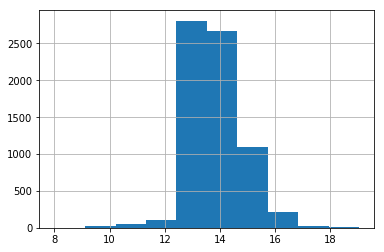

In [9]:
df["log_price"].hist()

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(good_ones[["log_price", "treatment", "after", "treatment_x_after"]])

In [ ]:
count

In [ ]:
len(merged)

In [ ]:
gpd.GeoDataFrame(df).plot()

In [ ]:
count_here = 0
for ix, item in merged.iterrows():
    if item["APT"].strip():
        assert item["APT_2"] == item["APT"]
    elif item["APARTMENT_NUMBER"].strip():
        count_here += 1
        assert item["APT_2"] == item["APARTMENT_NUMBER"].strip()
    else:
        assert item["APT_2"] == item["APT"]
count_here

In [13]:
df["BUILDING_CLASS_CATEGORY"].unique()

array([u'09  COOPS - WALKUP APARTMENTS               ',
       u'10  COOPS - ELEVATOR APARTMENTS             ',
       u'01  ONE FAMILY DWELLINGS                    ',
       u'07  RENTALS - WALKUP APARTMENTS             ',
       u'08  RENTALS - ELEVATOR APARTMENTS           ',
       u'14  RENTALS - 4-10 UNIT                     '], dtype=object)

In [ ]:
df[df["YEAR_BUILT"] > 0]['YearBuilt'].min()

In [ ]:
from datetime import datetime
cutoff = datetime(2017, 1, 1)

count = 0
indices = []
for ix, group in df.groupby(["Address", "APT"]):
    if ix[1] and group["SALE_DATE"].min() < cutoff and group["SALE_DATE"].max() >= cutoff:
        #print ix
        indices.append(group.index)
        #print "====="
        count += 1
i = indices[0]
for index in indices[1:]:
    i = i.append(index)

good_ones = df.loc[i]
# log price


In [10]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,FID_1,distance,geometry,SALE_MONTH,APT,APT_2,log_price,treatment,after,treatment_x_after,decade,decade_190,decade_191,decade_192,decade_193,decade_194,decade_195,decade_196,decade_197,decade_198,decade_200
0,1,HARLEM-EAST,09 COOPS - WALKUP APARTMENTS,2,1624,43,,C6,"156 EAST 97TH STREET, 1",,10029,.,.,.,.,.,1930,2,C6,200000,2017-02-06,MN,1624,43,111,158.02,1000,02,5,10029,E053,23,2820,1,11,1A,156 EAST 97 STREET,R7-2,,,,,,,,,,N,C6,02,0,P,156 EAST 97TH STREET,2725,8635,0,8635,0,0,0,0,0,0,2,1,5.0,18,18,27.00,100.92,27.0,66.0,,2,N,5,2,57600.0,483300.0,57600.0,307134.0,1930,1939,2006,,,3.17,3.44,0.0,6.5,1,1.016240e+09,0,015802,998184,225631,6b,,108S045,10603,,0.0,,1,16V2,0,263.791787,2784.667103,5922,292.976495,"POLYGON ((998221.8100000024 225671.1615999937,...",2017-2,1,1,12.206073,0,1,0,193,0,0,0,1,0,0,0,0,0,0
1,1,HARLEM-EAST,09 COOPS - WALKUP APARTMENTS,2,1624,43,,C6,"156 EAST 97TH STREET, 10",,10029,.,.,.,.,.,1930,2,C6,185000,2017-09-27,MN,1624,43,111,158.02,1000,02,5,10029,E053,23,2820,1,11,1A,156 EAST 97 STREET,R7-2,,,,,,,,,,N,C6,02,0,P,156 EAST 97TH STREET,2725,8635,0,8635,0,0,0,0,0,0,2,1,5.0,18,18,27.00,100.92,27.0,66.0,,2,N,5,2,57600.0,483300.0,57600.0,307134.0,1930,1939,2006,,,3.17,3.44,0.0,6.5,1,1.016240e+09,0,015802,998184,225631,6b,,108S045,10603,,0.0,,1,16V2,0,263.791787,2784.667103,5922,292.976495,"POLYGON ((998221.8100000024 225671.1615999937,...",2017-9,10,10,12.128111,0,1,0,193,0,0,0,1,0,0,0,0,0,0
2,1,HARLEM-EAST,09 COOPS - WALKUP APARTMENTS,2,1624,44,,C6,"154 EAST 97TH STREET, 14",,10029,.,.,.,.,.,1930,2,C6,218000,2017-01-04,MN,1624,44,111,158.02,1000,02,5,10029,E053,23,2820,1,11,1A,154 EAST 97 STREET,R7-2,,,,,,,,,,N,C6,02,0,P,154 EAST 97 STREET HD,2727,8640,0,8640,0,0,0,0,0,0,2,1,5.0,17,17,27.02,100.92,27.0,66.0,,2,N,5,2,57600.0,482850.0,57600.0,316471.0,1930,1939,2005,,,3.17,3.44,0.0,6.5,1,1.016240e+09,0,015802,998160,225644,6b,,108S045,10603,,0.0,,1,16V2,0,267.022638,2955.073169,5513,301.088264,"POLYGON ((998198.7176000029 225683.9459999949,...",2017-1,14,14,12.292250,0,1,0,193,0,0,0,1,0,0,0,0,0,0
3,1,HARLEM-EAST,09 COOPS - WALKUP APARTMENTS,2,1624,44,,C6,"154 EAST 97TH STREET, 16",,10029,.,.,.,.,.,1930,2,C6,300000,2017-05-24,MN,1624,44,111,158.02,1000,02,5,10029,E053,23,2820,1,11,1A,154 EAST 97 STREET,R7-2,,,,,,,,,,N,C6,02,0,P,154 EAST 97 STREET HD,2727,8640,0,8640,0,0,0,0,0,0,2,1,5.0,17,17,27.02,100.92,27.0,66.0,,2,N,5,2,57600.0,482850.0,57600.0,316471.0,1930,1939,2005,,,3.17,3.44,0.0,6.5,1,1.016240e+09,0,015802,998160,225644,6b,,108S045,10603,,0.0,,1,16V2,0,267.022638,2955.073169,5513,301.088264,"POLYGON ((998198.7176000029 225683.9459999949,...",2017-5,16,16,12.611538,0,1,0,193,0,0,0,1,0,0,0,0,0,0
4,1,HARLEM-EAST,09 COOPS - WALKUP APARTMENTS,2,1624,44,,C6,"154 EAST 97TH STREET, 12",,10029,.,.,.,.,.,1930,2,C6,218000,2017-08-29,MN,1624,44,111,158.02,1000,02,5,10029,E053,23,2820,1,11,1A,154 EAST 97 STREET,R7-2,,,,,,,,,,N,C6,02,